In [3]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

Shape of X_train: (11331, 5000)
Shape of X_test: (2833, 5000)
Shape of y_train: (11331,)
Shape of y_test: (2833,)
Using device: cpu
Epoch 1/20 - Train Loss: 0.4860 - Val Loss: 0.4726
Epoch 2/20 - Train Loss: 0.4681 - Val Loss: 0.4725
Epoch 3/20 - Train Loss: 0.4679 - Val Loss: 0.4756
Epoch 4/20 - Train Loss: 0.4684 - Val Loss: 0.4726
Epoch 5/20 - Train Loss: 0.4677 - Val Loss: 0.4728
Epoch 6/20 - Train Loss: 0.4672 - Val Loss: 0.4729
Epoch 7/20 - Train Loss: 0.4666 - Val Loss: 0.4740
Epoch 8/20 - Train Loss: 0.4683 - Val Loss: 0.4726
Epoch 9/20 - Train Loss: 0.4669 - Val Loss: 0.4739
Epoch 10/20 - Train Loss: 0.4678 - Val Loss: 0.4736
Epoch 11/20 - Train Loss: 0.4668 - Val Loss: 0.4727
Epoch 12/20 - Train Loss: 0.4676 - Val Loss: 0.4727
Epoch 13/20 - Train Loss: 0.4684 - Val Loss: 0.4740
Epoch 14/20 - Train Loss: 0.4675 - Val Loss: 0.4729
Epoch 15/20 - Train Loss: 0.4677 - Val Loss: 0.4725
Epoch 16/20 - Train Loss: 0.4672 - Val Loss: 0.4727
Epoch 17/20 - Train Loss: 0.4683 - Val Loss: 

c:\Users\rahul\Desktop\Deeplcapstone\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul\Desktop\Deeplcapstone\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rahul\Desktop\Deeplcapstone\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

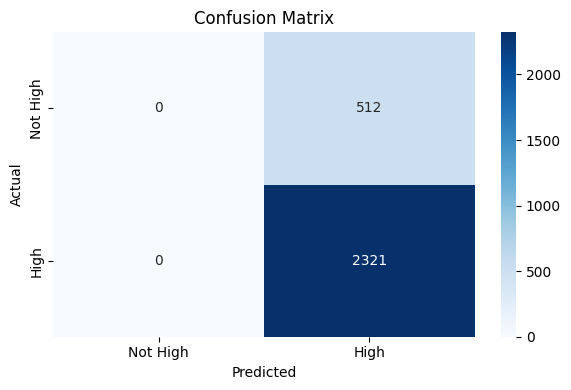

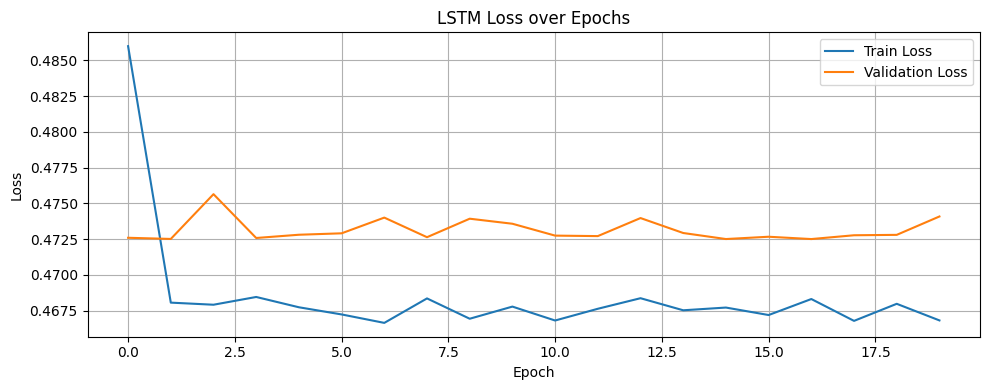

In [14]:
# 3. Neural Model Development (Threat Forecasting - PyTorch Version)
# Updated to load data from .npy files instead of a missing CSV


BASE_DIR = os.path.dirname(os.getcwd())
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models', 'neural_forecasting')
os.makedirs(MODEL_DIR, exist_ok=True)

# === Load Data ===
X_train = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_train.npy'))
X_test = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_test.npy'))
y_train = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_train.npy'))
y_test = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_test.npy'))

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# === Hyperparameters (Adjust these to manage memory) ===
SEQUENCE_LENGTH = 500  # Try a smaller value like 500 or 1000
BATCH_SIZE = 32        # Try a smaller value like 32 or 16

# === Preprocess Data to Reduce Sequence Length ===
X_train_truncated = X_train[:, :SEQUENCE_LENGTH]
X_test_truncated = X_test[:, :SEQUENCE_LENGTH]

X_train_seq = X_train_truncated.reshape((X_train_truncated.shape[0], X_train_truncated.shape[1], 1))
X_test_seq = X_test_truncated.reshape((X_test_truncated.shape[0], X_test_truncated.shape[1], 1))

# === Device Setup ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# === Tensors ===
tensor_x_train = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
tensor_y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
tensor_x_test = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
tensor_y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# === LSTM Model ===
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use last time step
        return self.fc(out)

# === Instantiate and Train ===
input_size = 1  # One feature per time step
model = LSTMClassifier(input_size=input_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(tensor_x_test)
        val_loss = criterion(val_outputs, tensor_y_test)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss.item():.4f}")

# === Save Model ===
torch.save(model.state_dict(), os.path.join(MODEL_DIR, "lstm_model.pt"))
print("LSTM model saved to models/neural_forecasting/lstm_model.pt")

# === Evaluation ===
y_pred_probs = model(tensor_x_test).detach().cpu().numpy()
y_pred_classes = (y_pred_probs > 0.5).astype(int)
y_true = tensor_y_test.cpu().numpy()

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not High', 'High'], yticklabels=['Not High', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === Loss Plot ===
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('LSTM Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()